In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import pytorch_lightning as L
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor, StochasticWeightAveraging
from pytorch_lightning.tuner.tuning import Tuner
from pytorch_lightning.loggers import TensorBoardLogger

import app.training.networks as net

from app.training.dataset import IVS_DataModule, DualInput_IVS_DataModule

# NN1 Residual Feed Forward NN

In [2]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

In [2]:
DataLoader_NN1 = IVS_DataModule()
DataLoader_NN3 = DualInput_IVS_DataModule()

# Learning Rate Tuning

### NN1

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USUARIO\PycharmProjects\MathThesis\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\USUARIO\PycharmProjects\MathThesis\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Finding best initial lr:   0%|          | 0/500 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 420 steps due to diverging loss.
Learning rate set to 1.2054050184530168e-05
Restoring states from the checkpoint path at c:\Users\USUARIO\PycharmProjects\MathThesis\.lr_find_7117a067-6ab3-4005-9358-ed6ee47565c7.ckpt
Restored all states from the checkpoint at c:\Users\USUARIO\PycharmProjects\MathThesis\.lr_find_7117a067-6ab3-4005-9358-ed6ee47565c7.ckpt


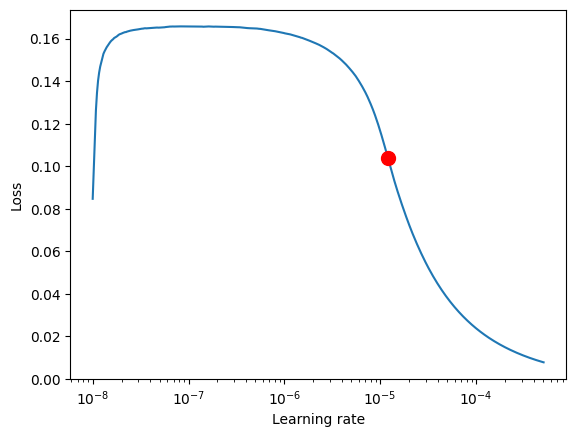

Suggested learning rate: 1.2054050184530168e-05


In [ ]:
model = net.NN1Residual()

# Instantiate the DataModule
data_module = IVS_DataModule()

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    save_top_k=1,
    mode="min",
    filename="best_model-{epoch:02d}-{val_loss:.2f}",
    save_weights_only=True
)

early_stopping_callback = EarlyStopping(
    monitor="val_loss",
    patience=5,
    mode="min",
    verbose=True
)

stochastic_weight_avg = StochasticWeightAveraging(1e-3)

lr_monitor = LearningRateMonitor(logging_interval="epoch")

# Define a Trainer
trainer = L.Trainer(callbacks=[early_stopping_callback, lr_monitor, stochastic_weight_avg], 
                    max_epochs=1)  # We only need one epoch for `lr_find`

# Use lr_find to identify the optimal learning rate
tuner = Tuner(trainer)
lr_finder = tuner.lr_find(model, datamodule=data_module, max_lr=4e-3, num_training=500)
assert lr_finder # lr_finder not NONE

# Plot the learning rate finder results
fig = lr_finder.plot(suggest=True, show=True)

# Retrieve the suggested learning rate
optimal_lr = lr_finder.suggestion()
print(f"Suggested learning rate: {optimal_lr}")


### NN3

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USUARIO\PycharmProjects\MathThesis\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\USUARIO\PycharmProjects\MathThesis\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Finding best initial lr:   0%|          | 0/1000 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 420 steps due to diverging loss.
Learning rate set to 0.003819442708400466
Restoring states from the checkpoint path at c:\Users\USUARIO\PycharmProjects\MathThesis\.lr_find_0dce1ff9-e5b1-4813-a952-9aac918057e7.ckpt
Restored all states from the checkpoint at c:\Users\USUARIO\PycharmProjects\MathThesis\.lr_find_0dce1ff9-e5b1-4813-a952-9aac918057e7.ckpt


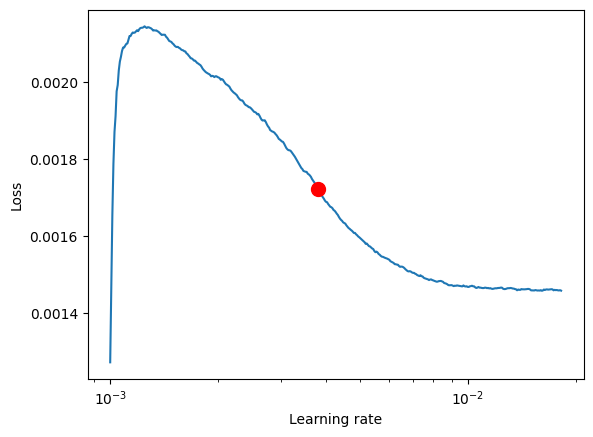

Suggested learning rate: 0.003819442708400466


In [9]:
from torch.utils.tensorboard.writer import SummaryWriter

writer = SummaryWriter()

nn1 = net.NN1Residual.load_from_checkpoint("lightning_logs\\version_33\\checkpoints\\best_model-epoch=141-val_loss=0.00.ckpt")
nn2 = net.NN2()
model = net.NN3(nn1=nn1, nn2=nn2)

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    save_top_k=1,
    mode="min",
    filename="best_model-{epoch:02d}-{val_loss:.2f}",
    save_weights_only=True
)

early_stopping_callback = EarlyStopping(
    monitor="val_loss",
    patience=5,
    mode="min",
    verbose=True
)

stochastic_weight_avg = StochasticWeightAveraging(1e-3)

lr_monitor = LearningRateMonitor(logging_interval="epoch")

# Define a Trainer
trainer = L.Trainer(callbacks=[early_stopping_callback, lr_monitor, stochastic_weight_avg], 
                    max_epochs=1)  # We only need one epoch for `lr_find`

DataLoader_NN3.prepare_data()
DataLoader_NN3.setup()

sample_input1, sample_input2, _ = DataLoader_NN3.dataset[0]  # Extract inputs
sample_input1 = sample_input1.unsqueeze(0)  # Add batch dimension
sample_input2 = sample_input2.unsqueeze(0)
# writer.add_graph(model, (sample_input1, sample_input2))

# # Use lr_find to identify the optimal learning rate
tuner = Tuner(trainer)
lr_finder = tuner.lr_find(model, datamodule=DataLoader_NN3, min_lr=1e-3, max_lr=1, num_training=1000)
assert lr_finder # lr_finder not NONE

# Plot the learning rate finder results
fig = lr_finder.plot(suggest=True, show=True)

# Retrieve the suggested learning rate
optimal_lr = lr_finder.suggestion()
print(f"Suggested learning rate: {optimal_lr}")

# Training NN1

### SetUp Loggers

In [3]:
# Logger for Model 1
logger_nn1 = TensorBoardLogger(
    save_dir="lightning_logs",
    name="nn1",
)

# Logger for Model 2
logger_nn3 = TensorBoardLogger(
    save_dir="lightning_logs",
    name="nn3",
)

### Callbacks

In [5]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    save_top_k=1,
    mode="min",
    filename="best_model-{epoch:02d}-{val_loss:.2f}",
    save_weights_only=True
)

early_stopping_callback = EarlyStopping(
    monitor="val_loss",
    patience=20,
    mode="min",
    check_on_train_epoch_end=True,
    verbose=True
)

stochastic_weight_avg = StochasticWeightAveraging(1e-3)

lr_monitor = LearningRateMonitor(logging_interval="epoch")

### Training

##### NN1

In [ ]:
nn1 = net.NN1Residual(lr=1.2e-05)

trainer = L.Trainer(accelerator='gpu', 
                    callbacks=[early_stopping_callback, checkpoint_callback, lr_monitor, stochastic_weight_avg], 
                    max_epochs=200)

trainer.fit(nn1, DataLoader_NN1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


##### NN3

In [8]:
model = net.NN1Residual.load_from_checkpoint("lightning_logs\\version_33\\checkpoints\\best_model-epoch=141-val_loss=0.00.ckpt")
nn3_lr = 0.003819442708400466
nn3 = net.NN3(model, net.NN2(lr=nn3_lr), lr=nn3_lr)

# Assure that nn1 is not trainable
print("Checking if NN1 is not trainable")
for name, param in nn3.nn1.named_parameters():
    # print(f"{name}: requires_grad={param.requires_grad}")
    assert param.requires_grad == False, f"Parameters in NN1 module {name} shant be trainable"
print("Check Passed")
    

trainer = L.Trainer(logger=logger_nn3,
                    accelerator='gpu', 
                    callbacks=[early_stopping_callback, checkpoint_callback, lr_monitor, stochastic_weight_avg], 
                    max_epochs=200)

trainer.fit(nn3, DataLoader_NN3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Checking if NN1 is not trainable
Check Passed


# Testing NN1

In [14]:
model = net.NN1Residual.load_from_checkpoint("lightning_logs\\version_33\\checkpoints\\best_model-epoch=141-val_loss=0.00.ckpt")
checkpoint = torch.load("lightning_logs\\version_33\\checkpoints\\best_model-epoch=141-val_loss=0.00.ckpt", map_location=lambda storage, loc: storage, weights_only=False)
checkpoint['hyper_parameters']

{'input_dim': 41, 'hidden_dim': 1024, 'output_dim': 130, 'lr': 1.2e-05}

In [ ]:
trainer.test(model, DataLoader_NN1)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USUARIO\PycharmProjects\MathThesis\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 adj_test_r2_score_epoch    0.9184309244155884
        test_loss         0.00029913688194938004
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.00029913688194938004,
  'adj_test_r2_score_epoch': 0.9184309244155884}]

In [12]:
nn3 = net.NN3.load_from_checkpoint("lightning_logs\\nn3\\version_3\\checkpoints\\best_model-epoch=22-val_loss=0.00.ckpt", nn1=net.NN1Residual(), nn2=net.NN2())
checkpoint = torch.load("lightning_logs\\nn3\\version_3\\checkpoints\\best_model-epoch=22-val_loss=0.00.ckpt", map_location=lambda storage, loc: storage, weights_only=False)
checkpoint["state_dict"].keys()

odict_keys(['nn1.input_head.0.weight', 'nn1.input_head.0.bias', 'nn1.hidden_residual_block.0.weight', 'nn1.hidden_residual_block.0.bias', 'nn1.hidden_residual_block.2.weight', 'nn1.hidden_residual_block.2.bias', 'nn1.hidden_residual_block.4.weight', 'nn1.hidden_residual_block.4.bias', 'nn1.hidden_residual_block.6.weight', 'nn1.hidden_residual_block.6.bias', 'nn1.output_layer.weight', 'nn1.output_layer.bias', 'nn2.input_head.0.weight', 'nn2.input_head.0.bias', 'nn2.input_head.1.weight', 'nn2.input_head.1.bias', 'nn2.input_head.1.running_mean', 'nn2.input_head.1.running_var', 'nn2.input_head.1.num_batches_tracked', 'nn2.hidden_residual_block.0.weight', 'nn2.hidden_residual_block.0.bias', 'nn2.hidden_residual_block.1.weight', 'nn2.hidden_residual_block.1.bias', 'nn2.hidden_residual_block.1.running_mean', 'nn2.hidden_residual_block.1.running_var', 'nn2.hidden_residual_block.1.num_batches_tracked', 'nn2.hidden_residual_block.3.weight', 'nn2.hidden_residual_block.3.bias', 'nn2.hidden_residua

In [ ]:
nn3.nn2

In [10]:
trainer.test(nn3, DataLoader_NN3)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USUARIO\PycharmProjects\MathThesis\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 adj_test_r2_score_epoch     0.616227388381958
   nn3_test_loss_epoch     0.0013556694611907005
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'nn3_test_loss_epoch': 0.0013556694611907005,
  'adj_test_r2_score_epoch': 0.616227388381958}]